# Introdução

> Este trabalho foi baseado no código de Chris McCormick e Nick Ryan, disponível em https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX

Este trabalho apresenta uma aplicação do modelo BERT na tarefa de classificação de texto.

Será analisando o banco de dados X extraído do site Kagle. Este banco possuí duas colunas, uma com o texto da notícia e outra indicando se a notícia é falsa ou não.

Utilizaremos neste trabalho a linguagem `Python` (versão 3.11.3), `R` (versão 4.2.1), o software `RStudio` (versão 2023.06.0+421), os pacotes em python `pandas` (versão 2.0.3), `transformers` (versão 4.30.2), `torch` (versão 2.0.1), e os pacotes em R .

# Setup

In [2]:
# Importando pacotes e funções
import os
import time
import datetime
import random
import torch
import captum
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statistics import mean
from collections import Counter
from langdetect import detect, DetectorFactory
from sklearn.metrics import matthews_corrcoef
from sklearn.decomposition import PCA
from adjustText import adjust_text
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler, Subset
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig, get_linear_schedule_with_warmup, BertModel
from captum.attr import LayerIntegratedGradients, TokenReferenceBase, visualization

In [3]:
# Declarando constantes
BANCO_ORIGINAL = r"dados/WELFake_Dataset.csv"
BANCO_FINAL = r"dados/data.csv"
PASTA_MODELO = f"dados/model_save_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}/"

device = torch.device("cpu")
os.environ['CURL_CA_BUNDLE'] = ''  # Caso surja o erro "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed" rode este comando e reduza a versão do pacote requets: "pip uninstall requests" e "pip install requests==2.27.1"

In [4]:
# Declarando a semente aleatória para que este código seja reprodutível
my_seed = 288933

random.seed(my_seed)
np.random.seed(my_seed)
torch.manual_seed(my_seed)
torch.cuda.manual_seed_all(my_seed)

# Pré-Processamento

O banco original possui 3 colunas e 72134 observações, das quais 35028 são notícias verdadeiras (label=0) e 37106 são falsas (label=1).

In [5]:
# # Importando o banco
# df = pd.read_csv(BANCO_ORIGINAL, index_col=0)

# df.info()
# df.head()

In [6]:
# df.groupby('label').size()

In [7]:
# # Renomeando a coluna de título e selecionando somente as colunas de título e de classificação
# df.rename({'title': 'titulo'}, axis=1, inplace=True)
# df = df[['titulo', 'label']]

# n_linhas_antes = len(df)
# df = df[~df['titulo'].isnull()]
# df = df[~df['label'].isnull()]

# n_linhas_depois = len(df)
# print(f'Número de observações removidas por valores nulos nas colunas de título ou de classificação: {n_linhas_antes- n_linhas_depois}')

In [8]:
# # Removendo linhas duplicadas
# n_linhas_antes = len(df)
# df.drop_duplicates(inplace=True)  # Valores de todas as colunas iguais
# df.drop_duplicates(subset='titulo', keep=False, inplace=True, ignore_index=True)  # Valores removidos aqui são títulos que possuem ambos os labels

# n_linhas_depois = len(df)
# print(f'Número de observações removidas por valores duplicados: {n_linhas_antes- n_linhas_depois}')

Alguns títulos estão em outras línguas além de inglês. Para removê-los, utilizaremos o pacote `langdetect` (versão 1.0.9).

In [9]:
# # Classificando os títulos em línguas
# DetectorFactory.seed = 0

# lingua = []
# for title in df['titulo']:
#     try:
#         lingua.append(detect(title))
#     except:
#         lingua.append('error')
#         pass

# print(Counter(lingua))

Vamos excluir as linhas em que o pacote `langdetect` classificou os títulos como língua russa, árabe, lituana, turca, polonesa, búlgara, grega, chinesa ou títulos que não puderam ser classificados pelo pacote. Vários títulos em inglês foram classificados nas demais línguas, e por tanto consideramos que tal classificação não foi muito acurada. Além disso, é importante ter em mente que vários títulos em línguas que não o inglês não puderam ser removidas do banco de forma automática, o que poderá provocar um ruído no modelo ajustado.

In [10]:
# # Removendo títulos em outras línguas
# n_linhas_antes = len(df)
# df.drop([idx for idx, l in enumerate(lingua) if l in ['ru', 'ar', 'lt', 'tr', 'pl', 'bg', 'el', 'zh-cn', 'error']]
#         ,axis=0  # linhas
#         ,inplace=True)
# df.reset_index(drop=True, inplace=True)

# n_linhas_depois = len(df)
# print(f'Número de títulos removidos por não estarem em inglês: {n_linhas_antes- n_linhas_depois}')

Para analisar o tamanho de cada título, vamos considerar o número de tokens do título tokenizado pelo modelo pré-treinado BERT Base. A informação do número máximo de tokens será útil na fase de ajuste do modelo.

In [11]:
# # Declarando o tokenizador do modelo BERT Base Uncased (que considera todas as letras como minúsculas)
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# # Para cada título, calcule o tamanho do vetor de tokens
# df['n_token'] = [len(tokenizer.encode(title, add_special_tokens=True)) for title in df['titulo']]

# # Analisando algumas estatísticas
# print('Mínimo de tokens: ', min(df['n_token']))
# print('Máximo de tokens: ', max(df['n_token']))
# print('Média de tokens: ', round(mean(df['n_token']), 4))
# print('Quantidade de tokens por percentil: ', np.quantile(df['n_token'], q=[.1, .2, .3, .4, .5, .6, .7, .8, .9]))
# print('Número de títulos com mais de 128 tokens: ', sum([i > 128 for i in df['n_token']]))
# print('Número de títulos com mais de 64 tokens: ', sum([i > 64 for i in df['n_token']]))
# print('Número de títulos com mais de 32 tokens: ', sum([i > 32 for i in df['n_token']]))

In [12]:
# # Banco pré-processado
# df.info()
# df.head()

In [13]:
# df.groupby('label').size()

O banco final possui 62134 observações, sendo que 55% delas são notícias falsas e 45% notícias verdadeiras, aproximadamente. Com o banco pré-processado pronto, vamos exportá-lo para um arquivo CSV.

In [14]:
# df.to_csv(BANCO_FINAL, index=False)

# Estatísticas descritivas

Importando os dados processados

In [15]:
df = pd.read_csv(BANCO_FINAL)

In [16]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62134 entries, 0 to 62133
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   titulo   62134 non-null  object
 1   label    62134 non-null  int64 
 2   n_token  62134 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.4+ MB


,titulo,label,n_token
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,1,35
1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,1,30
2,"Bobby Jindal, raised Hindu, uses story of Chri...",0,22
3,SATAN 2: Russia unvelis an image of its terrif...,1,25
4,About Time! Christian Group Sues Amazon and SP...,1,18


Obtendo a distribuição de palavras de cada texto

In [17]:
df.groupby('label').size()

label
0    34404
1    27730
dtype: int64

# Tunando o modelo pré-treinado

Vamos importar o modelo BERT base, pois não dispomos de capacidade computacional suficiente para rodar o modelo BERT large. Mais especificamente, utilizaremos o modelo BERT base uncased, que não diferencia letras maiúsculas e minusculas.

Usaremos a classe `BertForSequenceClassification`, que adapta o modelo BERT para conter, além da arquitetura original de 12 encoders, um classificador linear no topo. Como estamos fazendo uma classificação binária, vamos considerar somente duas categorias no classificador.

In [18]:
model_name = 'bert-base-uncased'

tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels = 2, output_attentions = False, output_hidden_states = False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

O primeiro passo que devemos fazer para ajustar o modelo é tokenizar as sentenças do banco. Para isso, vamos utilizar o método `encode_plus` para que cada sentença seja tokenizada pelo método WordPiece. Dentre as configurações, vamos truncar as sentenças que possuem mais do que 64 tokens para otimização. Como foi visto anteriormente, somente 3 sentenças do banco de dados possuem mais do que 64 tokens, portanto espera-se que o truncamento não afete os resultados do ajuste.

In [19]:
# Tokeniza todas as sentenças utilizando o método wordpiece
input_ids = []
attention_masks = []

for sentenca in df['titulo'].values:
    encoded_dict = tokenizer.encode_plus(
                        sentenca,
                        add_special_tokens = True,  # Inclui os tokens '[CLS]' e '[SEP]' no início e fim da lista, respectivamente
                        max_length = 64,  # Sentenças maiores do que 64 tokens serão truncadas e sentenças menores terão o restante da lista preenchida com o token '[PAD]'
                        truncation=True,  # Para usar o truncamento
                        padding='max_length',  # Para incluir o token '[PAD]' se necessario
                        return_attention_mask = True,  # Retorna a lista de atenção, que é 1 em na posição em que o token não for '[PAD]' e é 0 quando o token for '[PAD]'
                        return_tensors = 'pt'  # Retorna as listas como objeto do tipo tensor
                   )

    # Salva a sentença tokenizada e a lista de atenção em uma lista
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# Transforma a lista de tensores em um tensor com múltiplas listas
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(df['label'].values)

# Exemplificando o resultado com a primeira sentença do banco
print('Sentença original: ', df['titulo'].values[0])
print('Sentença tokenizada: ', input_ids[0])
print('Atenção: ', attention_masks[0])
print('Label: ', labels[0])

Sentença original:  LAW ENFORCEMENT ON HIGH ALERT Following Threats Against Cops And Whites On 9-11By #BlackLivesMatter And #FYF911 Terrorists [VIDEO]
Sentença tokenizada:  tensor([  101,  2375,  7285,  2006,  2152,  9499,  2206,  8767,  2114, 10558,
         1998, 12461,  2006,  1023,  1011,  2340,  3762,  1001,  2304,  3669,
         6961, 18900,  3334,  1998,  1001,  1042,  2100,  2546,  2683, 14526,
        15554,  1031,  2678,  1033,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])
Atenção:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Label:  tensor(1)


Com as sentenças tokenizadas, vamos dividir o banco entre treinamento, validação e teste, utilizando a proporção de separação 80%/10%/10% para cada partição, respectivamente.

In [20]:
# Combinando as listas obtidas na fase de tokenização para criar um objeto TensorDataset
dataset = TensorDataset(input_ids, attention_masks, labels)

# Calculando o número de sentenças que cada conjunto precisa ter para seguir a proporção 80-10-10
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Divindo os conjuntos aleatoriamente de acordo com o tamanho amostral calculado
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print('{:>5,} sentenças para treinamento'.format(train_size))
print('{:>5,} sentenças para validação'.format(val_size))
print('{:>5,} sentenças para teste'.format(test_size))

49,707 sentenças para treinamento
6,213 sentenças para validação
6,214 sentenças para teste


Em seguida, precisamos fazer escolhas acerca dos hiper-parâmetros do modelo. São eles o tamanho do lote (batch), a taxa de aprendizagem (learning rate) e o número de épocas (epoch).

Dado que treinar uma rede neural com todo o conjunto de dados de uma só vez pode ser caro computacionalmente e consumir muita memória, é possível dividir o conjunto de dados em lotes (batches) menores e atualizar os parâmetros do modelo com base nos gradientes médios calculados em cada lote. Quanto maior o tamanho do lote, mais precisa será a estimativa do gradiente e maior será poder computacional necessário.

A taxa de aprendizado, por sua vez, determina o tamanho do passo no qual os parâmetros do modelo são atualizados durante cada iteração do processo de treinamento. Quanto maior a taxa de aprendizado, mais rápida é a convergência dos parâmetros e maior é o risco do valor ótimo ser ultrapassado.

Uma época é uma passagem completa por todo o conjunto de dados de treinamento durante o processo de treinamento. Em cada época, o modelo processa todos os lotes no conjunto de dados de treinamento, calcula gradientes, atualiza parâmetros e avalia o desempenho do modelo. Poucas épocas podem levar ao underfitting, enquanto que muitas épocas podem levar ao overfitting.

Em Devlin, et al (2018), os autores recomendam utilizar um lote de 16 ou 32, uma taxa de aprendizagem de 5e-5, 3e-5 ou 2e-5 e um número de épocas de 2, 3 ou 4.

Vamos considerar o tamanho do lote de 32, a taxa de aprendizagem de 3e-5 e o número de épocas de 3.

In [21]:
batch_size = 32
learning_rate = 3e-5
epochs = 3

In [22]:
# Separando os conjuntos considerando o tamanho do lote:
# Para o treinamento, selecionamos os batches aleatoriamente. Já para validação e teste, selecionamos os batches sequencialmente
train_dataloader = DataLoader(train_dataset, sampler = RandomSampler(train_dataset), batch_size = batch_size)
validation_dataloader = DataLoader(val_dataset, sampler = SequentialSampler(val_dataset), batch_size = batch_size)
prediction_dataloader = DataLoader(test_dataset, sampler = SequentialSampler(test_dataset), batch_size = batch_size)

In [23]:
# O otimizador é o objeto responsável por realizar a atualização dos parâmetros do modelo
# Vamos utilizar o otimizador AdamW
optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate)

In [24]:
# Cria o objeto responsável por diminuir a taxa de aprendizagem linearmente na medida em que o modelo aprende
# O 'num_training_steps' é calculado como o número de lotes multiplicado pelo número de épocas
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = len(train_dataloader) * epochs)

É importante, também, declarar algumas funções auxiliares. Dentre elas, vamos declarar `flat_accuracy`, que retorna a proporção de acertos de predição e `format_time`, que retorna o tempo no formato de horas, minutos e segundos dado o número de segundos total.

In [25]:
# Função que calcula a acurácia dos valores preditos contra os labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [26]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))

    return str(datetime.timedelta(seconds=elapsed_rounded))

Finalmente, vamos iniciar o treinamento do modelo utilizando as variáveis auxiliares criadas até agora. É importante notar que esta é a etapa mais demorada e que mais demanda por computacional de todo o processo.

In [26]:
training_stats = []  # Vamos armazenar algumas estatísticas de avaliação do modelo neste objeto

tempo_inicial = time.time()

# Para cada época...
for epoch_i in range(0, epochs):
    # ========================================
    #               Treinamento
    # ========================================

    # Realiza uma passagem completa sobre o conjunto de treinamento

    print('\n======== Epoca {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Treinando...')
    
    t0 = time.time()  # Mede o tempo de treinamento desta época
    total_train_accuracy = 0  # Reinicia a acuracia total para esta época
    total_train_loss = 0  # Reinicia a perda total para esta época

    model.train()  # Coloca o modelo em modo de treinamento
    # O método 'train()' apenas muda o estado do objeto 'modelo', ele não treina o modelo
    # As camadas 'dropout' e 'batchnorm' se comportam de maneira diferente durante o treinamento
    # em relação ao teste (https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    
    # Para cada lote (batch) dos dados de treinamento...
    for step, batch in enumerate(train_dataloader):
        # Imprimi o progresso para o usuário a cada 40 lotes
        if step % 40 == 0 and not step == 0:
            print('  Lote {:>5,}  de  {:>5,}.    Tempo decorrido: {:}.'.format(step, len(train_dataloader), format_time(time.time() - t0)))

        # 'batch' é um objeto que contém 3 tensores:
        #   [0]: input_ids
        #   [1]: attention_masks
        #   [2]: labels
        # Vamos copiar cada tensor para a CPU utilizando o método 'to()'
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()  # Precisamos limpar quaisquer gradientes calculados anteriormente antes de realizar o passo backward
        # O PyTorch não faz isso automaticamente devido a características do treinamento de RNN's
        # (https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        
        result = model(b_input_ids,
                       token_type_ids=None,  # 'None' porque não estamos no contexto de next sentence prediction
                       attention_mask=b_input_mask,
                       labels=b_labels,
                       return_dict=True)
        # Realiza o treinamento do modelo com os dados deste lote, utilizando a função forward
        # Embora utilizamos a função 'model', os argumentos desta função estão indo para outra função chamada 'forward'
        # A documentação dos resultados retornados está aqui:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput

        loss = result.loss  # Perda de classificação. O quão "longe" a predição do modelo foi em relação ao label verdadeiro
        logits = result.logits  # Escore de classificação
        # Para cada sentença, o label com o maior escore será aquele que o modelo escolherá como o label verdadeiro da sentença

        total_train_loss += loss.item()  # Acumulando o erro de treinamento em todos os lotes para que possamos calcular a perda média ao final
        
        # Movendo os logits e labels para a CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_train_accuracy += flat_accuracy(logits, label_ids)  # Acumula a acuracia de treinamento

        loss.backward()  # Executa o método backward para calcular os gradientes

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Isto evita o problema de gradiente explosivo

        optimizer.step()  # Atualiza os parâmetros do modelo e executa um passo utilizando o gradiente computado
        
        scheduler.step()  # Atualiza a taxa de aprendizado
    
    avg_train_accuracy = total_train_accuracy / len(train_dataloader)  # Calcula a acuracia media de treinamento
    print("  Acuracia: {0:.2f}".format(avg_train_accuracy))

    avg_train_loss = total_train_loss / len(train_dataloader)  # Calcula a perda média dos lotes

    training_time = format_time(time.time() - t0)

    print("  Perda media de treinamento: {0:.2f}".format(avg_train_loss))
    print("  Treinamento da epoca levou: {:}".format(training_time))

    # ========================================
    #               Validação
    # ========================================
    # Finalizada a época de treinamento, vamos medir a performance do modelo nos dados de validação

    print("\nValidando...")

    t0 = time.time()

    model.eval()  # Coloca o modelo em modo de validação

    total_eval_accuracy = 0
    total_eval_loss = 0

    for batch in validation_dataloader:
        # Similar ao treinamento, vamos armazenar os valores do lote
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # 'torch.no_grad()' economiza tempo de processamento por não computar algumas métricas que só são usadas na fase de treinamento
        with torch.no_grad():
            result = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)
            # Executa a função 'forward' com os dados de validação

        loss = result.loss
        logits = result.logits

        total_eval_loss += loss.item()  # Acumulando o erro de validação em todos os lotes para que possamos calcular a perda média ao final

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)  # Acumula a acuracia de validação


    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)  # Calcula a acuracia media de validação
    print("  Acuracia: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)  # Calcula a perda média dos lotes

    validation_time = format_time(time.time() - t0)

    print("  Perda de validacao: {0:.2f}".format(avg_val_loss))
    print("  Validacao levou: {:}".format(validation_time))

    # Guardando estatísticas desta época
    training_stats.append(
        {
            'epoca': epoch_i + 1,
            'Perda de treinamento': avg_train_loss,
            'Perda de validacao': avg_val_loss,
            'Acuracia de treinamento': avg_train_accuracy,
            'Acuracia de validacao': avg_val_accuracy,
            'Tempo de treinamento': training_time,
            'Tempo de validacao': validation_time
        }
    )

print("\nTreinamento concluído!")
print("Tempo total de treinamento: {:} (hh:mm:ss)".format(format_time(time.time()-tempo_inicial)))


======== Epoca 1 / 3 ========
Treinando...
  Lote    40  de  1,554.    Tempo decorrido: 0:05:28.
  Lote    80  de  1,554.    Tempo decorrido: 0:11:26.
  Lote   120  de  1,554.    Tempo decorrido: 0:17:15.
  Lote   160  de  1,554.    Tempo decorrido: 0:23:26.
  Lote   200  de  1,554.    Tempo decorrido: 0:29:37.
  Lote   240  de  1,554.    Tempo decorrido: 0:35:47.
  Lote   280  de  1,554.    Tempo decorrido: 0:41:59.
  Lote   320  de  1,554.    Tempo decorrido: 0:48:08.
  Lote   360  de  1,554.    Tempo decorrido: 0:53:55.
  Lote   400  de  1,554.    Tempo decorrido: 1:00:06.
  Lote   440  de  1,554.    Tempo decorrido: 1:06:16.
  Lote   480  de  1,554.    Tempo decorrido: 1:12:27.
  Lote   520  de  1,554.    Tempo decorrido: 1:18:38.
  Lote   560  de  1,554.    Tempo decorrido: 1:24:48.
  Lote   600  de  1,554.    Tempo decorrido: 1:30:33.
  Lote   640  de  1,554.    Tempo decorrido: 1:36:52.
  Lote   680  de  1,554.    Tempo decorrido: 1:42:59.
  Lote   720  de  1,554.    Tempo deco

Vamos exportar o modelo para não perder o progresso!

In [27]:
# Salvando o modelo treinado e o tokenizador
if not os.path.exists(PASTA_MODELO):
    os.makedirs(PASTA_MODELO)

model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(PASTA_MODELO)
tokenizer.save_pretrained(PASTA_MODELO)

# Salvando as estatísticas do modelo
df_stats = pd.DataFrame(data=training_stats).set_index('epoca')
df_stats.to_csv(os.path.join(PASTA_MODELO, 'training_stats.csv'))

# Salvando os 'indices' de cada conjunto de treinamento. Desta forma, podemos recriar os bancos de treinamento, validação e teste
# Os 'indices' vão de 0 a len(dataset)-1, portanto eles representam a ordem de cada linha de df e não necessariamente seu index
df_indexes = pd.DataFrame({'set': ['train' for _ in range(len(train_dataset))] + ['validation' for _ in range(len(val_dataset))] + ['test' for _ in range(len(test_dataset))]
                          ,'indice': train_dataset.indices + val_dataset.indices + test_dataset.indices})
df_indexes.to_csv(os.path.join(PASTA_MODELO, 'indices_set.csv'), index=False)

In [28]:
# Analisando as estatísticas de treinamento
df_stats

,Perda de treinamento,Perda de validacao,Acuracia de treinamento,Acuracia de validacao,Tempo de treinamento,Tempo de validacao
epoca,,,,,,
1,0.194304,0.152900,0.921976,0.944872,3:55:57,0:10:01
2,0.094286,0.182497,0.967002,0.944551,3:45:13,0:09:05
3,0.042467,0.242404,0.987934,0.949679,3:44:42,0:09:19


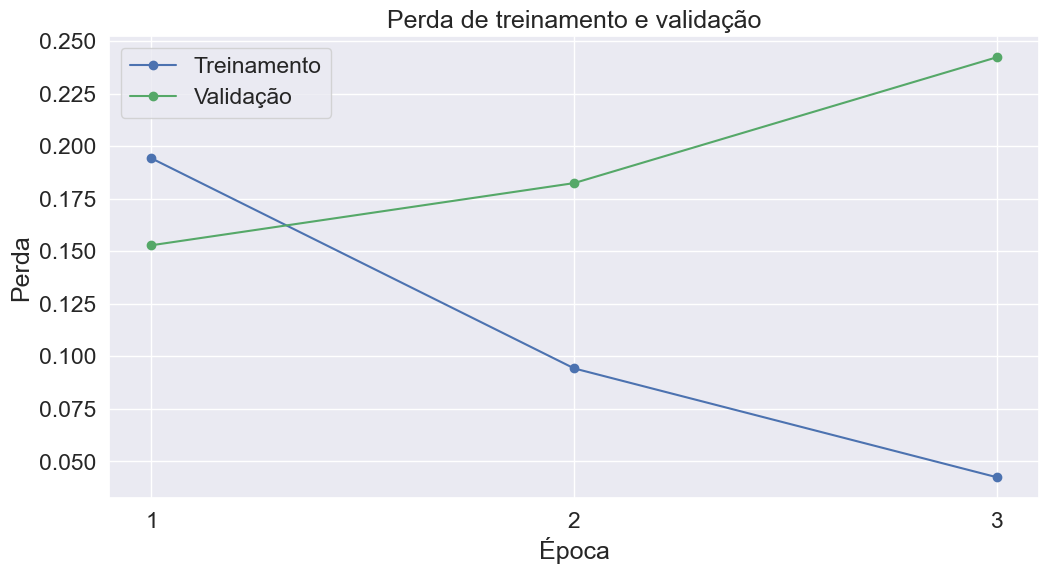

In [29]:
%matplotlib inline

# Usando o estilo do pacote seaborn
sns.set(style='darkgrid')

# Aumentando o tamanho do plot e da fonte
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plotando as curvas de perda
plt.plot(df_stats['Perda de treinamento'], 'b-o', label="Treinamento")
plt.plot(df_stats['Perda de validacao'], 'g-o', label="Validação")

# Escrevendo as legendas
plt.title("Perda de treinamento e validação")
plt.xlabel("Época")
plt.ylabel("Perda")
plt.legend()
plt.xticks([1, 2, 3])

plt.show()

# Avaliando o modelo

Depois do ajuste, vamos avaliar a performance do modelo no banco de teste

In [27]:
# Para carregar o modelo ajustado de volta, basta trocar o nome do modelo pré-treinado pela pasta onde o modelo foi salvo
PASTA_MODELO = "dados/model_v1/"

tokenizer = BertTokenizer.from_pretrained(PASTA_MODELO)
model = BertForSequenceClassification.from_pretrained(PASTA_MODELO, num_labels = 2, output_attentions = False, output_hidden_states = False)

# Copiando o modelo para o dispositivo, no nosso caso, a CPU
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

Podemos recriar o banco de teste após o ajuste, possibilitando o treinamento e teste do modelo em seções diferentes. Caso o teste seja feita na mesma seção, não é necessário rodar o bloco abaixo.

In [28]:
# Utilizando o mapping de observação ao banco correspondente, caso seja de interesse rodar o teste em uma seção separada do treinamento
df_indexes = pd.read_csv(os.path.join(PASTA_MODELO, 'indices_set.csv'))
test_indexes = df_indexes.loc[df_indexes['set'] == 'test', 'indice'].tolist()

Vamos executar os mesmos passo para o teste que foi feito na validação.

In [29]:
# test_dataset = Subset(dataset, test_indexes)
# prediction_dataloader = DataLoader(test_dataset, sampler = SequentialSampler(test_dataset), batch_size = batch_size)

# model.eval()  # Coloca o modelo em modo de validação

# predictions , true_labels, word_embeddings = [], [], []

# # Para cada lote do banco de teste...
# for batch in prediction_dataloader:
#     batch = tuple(t.to(device) for t in batch)
#     b_input_ids, b_input_mask, b_labels = batch

#     with torch.no_grad():
#         # Executa a função 'forward' para armazenar os valores preditos
#         result = model(b_input_ids,
#                         token_type_ids=None,
#                         attention_mask=b_input_mask,
#                         return_dict=True)
        
#         # Chama o método 'bert' de 'model', para obter os word embeddings de cada sentença
#         word_embeddings_aux = model.bert(b_input_ids,
#                         token_type_ids=None,
#                         attention_mask=b_input_mask,
#                         return_dict=True)

#     logits = result.logits

#     logits = logits.detach().cpu().numpy()
#     label_ids = b_labels.to('cpu').numpy()

#     # Armazenando os valores reais e preditos
#     predictions.append(logits)
#     true_labels.append(label_ids)

#     # Armazenando os word embeddings
#     word_embeddings.append(word_embeddings_aux['last_hidden_state'].numpy())

# print('Concluido!')

In [30]:
# # Transformando a lista de arrays para arrays
# predictions = np.concatenate(predictions, axis=0)
# true_labels = np.concatenate(true_labels, axis=0)
# word_embeddings = np.concatenate(word_embeddings, axis=0)

Vamos salvar os `np.array`'s `predictions`, `true_labels` e `word_embeddings` para economizar tempo de processamento

In [31]:
# Criando as pastas para armazenars os arrays de predictions, true_labels e word_embeddings
PASTA_AVALIACAO = os.path.join(PASTA_MODELO, 'evaluation')

if not os.path.exists(PASTA_AVALIACAO): os.makedirs(PASTA_AVALIACAO)

In [32]:
# # Salvando todos os arrays
# np.save(os.path.join(PASTA_AVALIACAO, f'predictions.npy'), predictions)
# np.save(os.path.join(PASTA_AVALIACAO, f'true_labels.npy'), true_labels)
# np.save(os.path.join(PASTA_AVALIACAO, f'word_embeddings.npy'), word_embeddings)  # > 1Gb

In [33]:
# Importando todos os arrays
logits = np.load(os.path.join(PASTA_AVALIACAO, f'predictions.npy'))
true_labels = np.load(os.path.join(PASTA_AVALIACAO, f'true_labels.npy'))
word_embeddings = np.load(os.path.join(PASTA_AVALIACAO, f'word_embeddings.npy'))

predictions = np.argmax(logits, axis=1).flatten()

In [34]:
# Obtendo uma lista dos tokens de cada sentença do banco de teste
test_tokens = []
for i in test_indexes:
    test_tokens.append(tokenizer.convert_ids_to_tokens([i for i in input_ids[i].tolist() if i != 0]))

## Medidas de avaliação

Lembrando que a classe está levemente desbalanceada em favor de notícias verdadeiras

In [35]:
df.loc[test_indexes].groupby('label').size()

label
0    3448
1    2766
dtype: int64

In [36]:
tp = sum(predictions[true_labels == 1] == 1)  # verdadeiro positivo
tn = sum(predictions[true_labels == 0] == 0)  # verdadeiro negativo
fp = sum(predictions[true_labels == 0] == 1)  # falso positivo
fn = sum(predictions[true_labels == 1] == 0)  # falso negativo

# Declarando os valores acima mas como percentuais do número de obsevações do banco de teste
tp_perc = '{0:.4%}'.format(tp/(tp + tn + fp + fn))
tn_perc = '{0:.4%}'.format(tn/(tp + tn + fp + fn))
fp_perc = '{0:.4%}'.format(fp/(tp + tn + fp + fn))
fn_perc = '{0:.4%}'.format(fn/(tp + tn + fp + fn))

Matriz de confunsão

In [37]:
pd.DataFrame({'Predito positivo': [tp, fp], 'Predito negativo': [fn, tn]}, index=['Verdadeiro positivo', 'Verdadeiro negativo'])

,Predito positivo,Predito negativo
Verdadeiro positivo,2565,201
Verdadeiro negativo,132,3316


Matriz de confusão considerando proporções

In [38]:
pd.DataFrame({'Predito positivo': [tp_perc, fp_perc], 'Predito negativo': [fn_perc, tn_perc]}, index=['Verdadeiro positivo', 'Verdadeiro negativo'])

,Predito positivo,Predito negativo
Verdadeiro positivo,41.2778%,3.2346%
Verdadeiro negativo,2.1242%,53.3634%


Calculando acurácia, precisão, recall e F1 do modelo.

In [39]:
accuracy = (tp + tn)/(tp + tn + fp + fn)
precision = tp/(tp + fp)
sensitivity = tp/(tp + fn)
specificity = fp/(tn + fp)
f1_score = 2*(precision * sensitivity)/(precision + sensitivity)
mcc = matthews_corrcoef(true_labels, predictions)

print(f"{'Acurácia no banco de teste: ':<35}{accuracy:>.4%}")
print(f"{'Precisão no banco de teste: ':<35}{precision:>.4%}")
print(f"{'F1 no banco de teste: ':<35}{f1_score:>.4%}")
print(f"{'Sensibilidade no banco de teste: ':<35}{sensitivity:>.4%}")
print(f"{'Especificidade no banco de teste: ':<35}{specificity:>.4%}")
print(f"{'MCC no banco de teste: ':<35}{specificity:>.4%}")

Acurácia no banco de teste:        94.6411%
Precisão no banco de teste:        95.1057%
F1 no banco de teste:              93.9044%
Sensibilidade no banco de teste:   92.7332%
Especificidade no banco de teste:  3.8283%
MCC no banco de teste:             3.8283%


Para avaliar o ajuste do modelo ajustado no banco de teste, utilizaremos o Coeficiente de Correção de Matthews (MCC), que se assemelha ao Coeficiente de Correlação de Pearson por assumir valores entre -1 e +1. Quanto mais próximo de +1 for o MCC, melhor será a perfomance do modelo no banco de teste. Universalmente, se considera 0,5 como um valor razoavelmente bom de ajuste.

## Visualizando o ajuste

### Gradientes Integrados

Vamos utilizar o método de Gradientes Integrados (Sundararajan et al., 2017) para visualizar a importância que cada token nas senteças tiveram para a classificação. Para utilizar este método com o modelo BERT, precisamos usar os word embeddings das sentenças e não os tokens.

### Word Embeddings

Plotando algumas sentenças utilizando PCA

In [40]:
pca = PCA(n_components=2)

word_embeddings_pca = [pca.fit_transform(we) for we in word_embeddings]

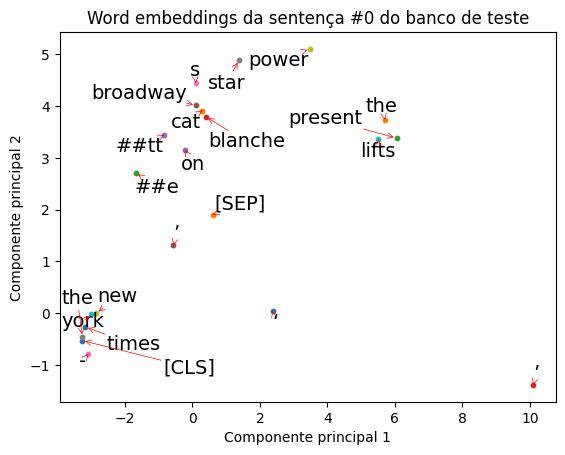

In [41]:
%matplotlib inline

word_id = 0
tokens = test_tokens[word_id]
plot_x = word_embeddings_pca[word_id][:len(tokens), 0]
plot_y = word_embeddings_pca[word_id][:len(tokens), 1]

points = []
texts = []
for i, label in enumerate(tokens):
    point = plt.scatter(plot_x[i], plot_y[i], marker='o', s=10, label=label)  # You can adjust marker size
    text = plt.text(plot_x[i], plot_y[i], label, fontsize=14, ha='center', va='center')

    points.append(point)
    texts.append(text)

plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.title(f'Word embeddings da sentença #{word_id} do banco de teste')

adjust_text(texts, plot_x, plot_y, arrowprops=dict(arrowstyle="->", color='r', lw=0.5), autoalign='')  # , only_move={'points':'y', 'text':'y'}
plt.show()